# KPP test stand efficiency analysis 

In [1]:
# External libraries
import sys
import awkward as ak
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Mu2e pyutils
sys.path.append("../EventNtuple/utils/pyutils")

import pyprint 
import pyplot 

pr = pyprint.Print()
pl = pyplot.Plot()

# anapytools
from anapytools.read_data import DataReader
reader = DataReader()

# EffAna methods
sys.path.append("../Utils")
from processor import Processor # Process rec trees into ak
from clean import Clean # Filter data
from crvaging019 import CrvAging019 # Get PEs/layer for crvaging-019
from cuts import Cuts # Apply cuts
from trigger import Trigger # Trigger
from sort import Sort # Sort PEs / layer
from histogrammer import Histogrammer # Accumulate histograms 
from scan_inefficiency import ScanInefficiency # Scan inefficiency

## Process data

In [2]:
# Initialise
reader = DataReader()
processor = Processor(reader=reader)

# Configure dataset
defname = "rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.root"
run_number="002101"

# Get filelist
filelist = processor.get_filelist(defname, run_number)

# Process files
arrays = processor.process_files_parallel(filelist)

# Print array info
arrays.type.show()
print("\n → FEBs:", len(arrays['PEsTemperatureCorrected'][0,:,0]))
print(" → Channels / FEB:", len(arrays['PEsTemperatureCorrected'][0,0,:]))

---> Loading Processor...
filelist: ['rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_003.root', 'rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root']

---> Starting parallel processing with 5 workers...
Processing 5 files in total

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_002.root processed successfully!
  → Events in this file: 149914
  → Progress: 1/5 files (20.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_000.root processed successfully!
  → Events in this file: 157287
  → Progress: 2/5 files (40.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_001.root processed successfully!
  → Events in this file: 156933
  → Progress: 3/5 files (60.0%)

✓ rec.mu2e.CRV_wideband_cosmics.CRVWB-000-010-000.002101_004.root processed succe

## Clean data 

In [3]:
pr.PrintNEvents(arrays)


---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2101
subrunNumber: 2
spillIndex: 3
spillNumber: 567
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0.945, 0, 34.5, 50.4, 0, 0, 0, 0], ...]
-------------------------------------------------------------------------------------



In [4]:
clean = Clean(arrays)
arrays = clean.remove_negative_PEs()
# Check structure 
arrays["PEsTemperatureCorrected"].type.show()

---> Loading Clean...
Removing 3873/773205 events containing negative PE values
769332 * 8 * 64 * float32


## Get PEs/layer

In [5]:
crvaging019 = CrvAging019(arrays)
arrays = crvaging019.crv_L_end()
arrays = crvaging019.crv_T(single_ended=True)
arrays = crvaging019.crv_DS()
print()
arrays.type.show()
pr.PrintNEvents(arrays, 1)

---> Loading CrvAging019...

---> Mapping CRV-L-end
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-T
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

---> Mapping CRV-DS
Layer 0 matches ✓
Layer 1 matches ✓
Layer 2 matches ✓
Layer 3 matches ✓

769332 * {
    runNumber: int32,
    subrunNumber: int32,
    spillIndex: int32,
    spillNumber: int32,
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    PEs_per_layer_L_end: 4 * 32 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32
}

---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2101
subrunNumber: 2
spillIndex: 3
spillNumber: 567
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0.945, 0, 34.5, 50.4, 0, 0, 0, 0], ...]
PEs_per_layer_L_end: [[0, 2.04, 41.8, 52.7, 0, 0, 0, 1.02, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0

## Apply physics cuts

In [6]:

# tot_PEs = ak.sum(
#    ak.flatten(arrays['PEsTemperatureCorrected'], axis=-1),
#    axis=-1
# )

def get_tot_PEs(arrays): 
    
    # Sum over each module's layers
    tot_PEs = (
        ak.sum(ak.sum(arrays['PEs_per_layer_L_end'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_T'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_DS'], axis=-1), axis=-1)
    )

    return tot_PEs 
tot_PEs = get_tot_PEs(arrays)
tot_PEs.type.show()

769332 * float32



---> Loading Cuts...
Initial number of events: 769332


/home/sgrant/Wideband/Notebooks/../EventNtuple/utils/pyutils/pyplot.py:187: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(xmin, xmax)



---> Wrote:
	../Images/EffAna/h1_tot_PEs_cut.png


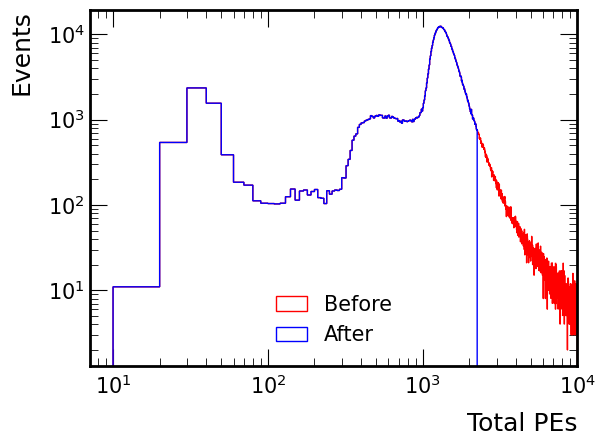


Total PE cut (< 2250):
Events removed: 54539 (7.1%)
Events remaining: 714793 (92.9% of initial)

---> Wrote:
	../Images/EffAna/h1_fid_cut.png


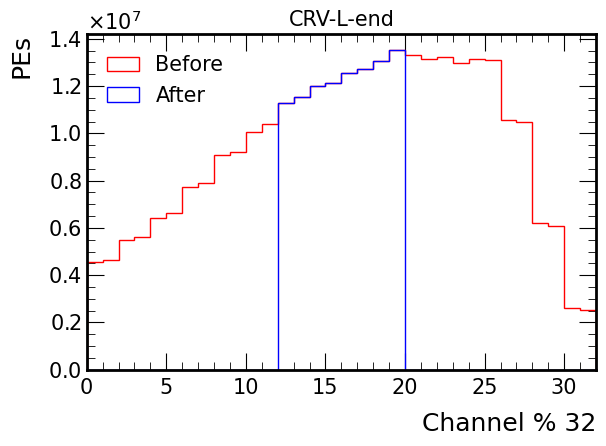


Fiducial cut (channels 12-19):
714793 * {
    runNumber: int32,
    subrunNumber: int32,
    spillIndex: int32,
    spillNumber: int32,
    eventNumber: int32,
    PEsTemperatureCorrected: 8 * 64 * float32,
    PEs_per_layer_T: 4 * 32 * float32,
    PEs_per_layer_DS: 4 * 32 * float32,
    PEs_per_layer_L_end: var * var * ?float32
}


In [41]:
cuts = Cuts(arrays, verbose=True)

max_PEs = 2250
# 0,1,2,3 4,5,6,7 8,9,10,11 12,13,14,15 16,17,18,19 20,21,22,23 24,25,26,27, 28,29,30,31
lo_chan=12
hi_chan=19
min_counter_hits=8*2
max_counter_hits=100

# Make a copy
arrays_cut = ak.copy(arrays)

arrays_cut = cuts.tot_PE_cut(max_PEs=max_PEs, fout="../Images/EffAna/h1_tot_PEs_cut.png") 
arrays_cut = cuts.fiducial_cut(lo_chan=lo_chan, hi_chan=hi_chan, fout="../Images/EffAna/h1_fid_cut.png") 
# arrays_cut = cuts.counters_hit_cut(min_counter_hits=min_counter_hits, max_counter_hits=max_counter_hits)

arrays_cut.type.show()

## Trigger

In [8]:
# Initiliase
trigger = Trigger(arrays_cut)
# Find triggers
arrays_cut = trigger.get_triggers()
# Apply triggers
arrays_cut = trigger.apply_triggers()

---> Loading Trigger...
---> Triggering
-> 88559/714793 = 12.39% events have triggers


## Sort PEs in test module

In [9]:
sort = Sort()
arrays_cut["PEs_per_layer_T_sorted"] = sort.sort_layer_PEs(arrays_cut['PEs_per_layer_T'])
sort.print_sorted_layer_PEs(arrays_cut['PEs_per_layer_T_sorted'])

---> Loading Sort...
Sorted PEs:
0 [74.6, 106, 124, 142]
1 [89.2, 110, 121, 187]
2 [81.2, 89.6, 100, 103]
3 [110, 120, 121, 178]
4 [67, 89.4, 115, 132]
5 [113, 116, 135, 143]
6 [100, 113, 117, 139]
7 [87.4, 107, 120, 207]
8 [64.1, 87.2, 87.9, 103]
9 [73.6, 97.1, 152, 152]
...


x_max = 923.2349243164062
---> Loading Hists...

---> Wrote:
	 ../Images/EffAna/h1_sorted_PEs.png


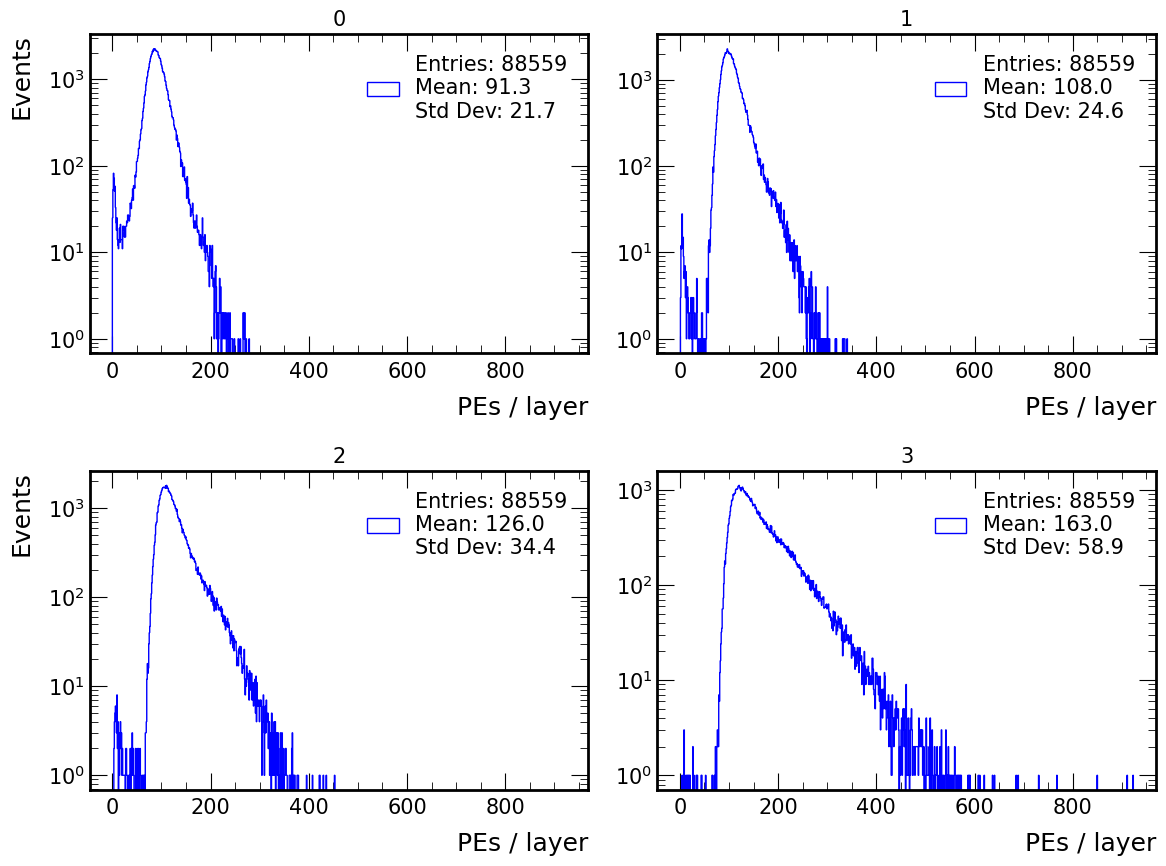

In [40]:
x_max = max(ak.flatten(arrays_cut['PEs_per_layer_T_sorted'][:,3], axis=None))
print(f"x_max = {x_max}")
histogrammer = Histogrammer(nbins=int(x_max), x_range=(0, x_max)) 
hists = histogrammer.acc_hists(arrays_cut)
histogrammer.plot_hists(hists, fout="../Images/EffAna/h1_sorted_PEs.png")

## Scan inefficiency 

---> Loading Inefficiency...
PE thresholds to scan:
[ 10.  15.  20.  25.  30.  35.  40.  45.  50.  55.  60.  65.  70.  75.
  80.  85.  90.  95. 100. 105. 110. 115. 120. 125. 130. 135. 140. 145.
 150.]

---> Wrote:
	 ../Images/EffAna/gr_eff_arr.png


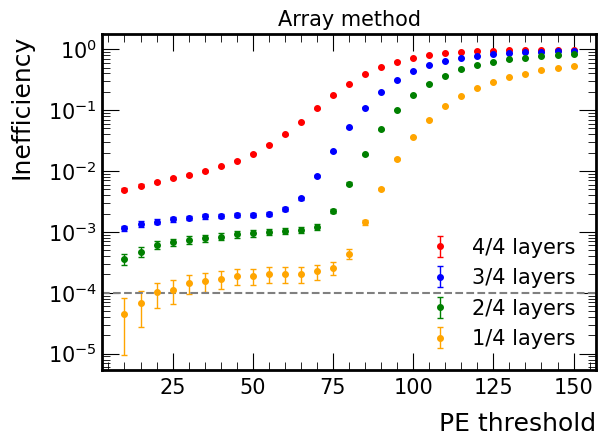


---> Wrote:
	 ../Images/EffAna/gr_eff_hist.png


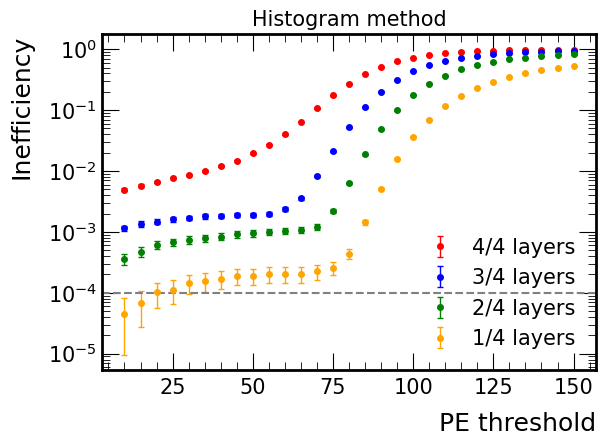

In [39]:
inefficiency = ScanInefficiency()

# Array method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_arrays(arrays_cut)
inefficiency.plot_scan(ineff, ineff_err, title="Array method", fout="../Images/EffAna/gr_eff_arr.png")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 

# Histogram method
thresholds, ineff, ineff_err = inefficiency.scan_ineff_hists(hists)
inefficiency.plot_scan(ineff, ineff_err, title="Histogram method", fout="../Images/EffAna/gr_eff_hist.png")

# print("threshold, ineff")
# for i_thres, threshold in enumerate(thresholds):
#     print(f"{threshold}, {ineff[1][i_thres]}") 
    

## Further analysis

In [12]:
def event_display(arrays, runNumber, subrunNumber, eventNumber, spillNumber, spillIndex, fout=None): 
    # Get event
    this_event = arrays[ 
        (arrays["runNumber"]==runNumber) & 
        (arrays["subrunNumber"]==subrunNumber) &
        (arrays["eventNumber"]==eventNumber) &
        (arrays["spillNumber"]==spillNumber) &
        (arrays["spillIndex"]==spillIndex) 
    ]

    # pr.PrintNEvents(this_event)

    # Get rows
    rows = np.array([
        this_event["PEs_per_layer_L_end"][0][3],  # each row is 20 mm high
        this_event["PEs_per_layer_L_end"][0][2], 
        this_event["PEs_per_layer_L_end"][0][1],
        this_event["PEs_per_layer_L_end"][0][0],
        this_event["PEs_per_layer_T"][0][3],
        this_event["PEs_per_layer_T"][0][2],
        this_event["PEs_per_layer_T"][0][1],
        this_event["PEs_per_layer_T"][0][0],
        this_event["PEs_per_layer_DS"][0][3],
        this_event["PEs_per_layer_DS"][0][2],
        this_event["PEs_per_layer_DS"][0][1],
        this_event["PEs_per_layer_DS"][0][0]
    ])

    fig, ax = plt.subplots(figsize=(12,8))

    # Merge adjacent counters 
    merged_rows = []
    for row in rows:
        pairs = row.reshape(-1, 2)
        merged_row = np.sum(pairs, axis=1)
        merged_rows.append(merged_row)
    merged_rows = np.array(merged_rows)
    
    # Calculate positions
    n_channels = merged_rows.shape[1]
    x_edges = np.linspace(n_channels, 0, n_channels+1)
    y_positions = np.arange(13)  # 0 to 8 for edges of 8 layers
    
    # Create heatmap
    im = ax.pcolormesh(x_edges, y_positions, merged_rows, 
                       cmap="coolwarm", vmax=None)
    ax.invert_yaxis()
    ax.invert_xaxis()
    
    # For ticks and grid, use the centers of the bins
    y_ticks = np.arange(12)  # 0 to 7 for centers of 8 layers
    ax.set_yticks(y_ticks + 0.5)  # Center the ticks in the bins
    ax.set_yticklabels(y_ticks)  # Show original layer numbers

    # Add text annotations for non-zero values
    for i in range(merged_rows.shape[0]):
        for j in range(merged_rows.shape[1]):
            value = merged_rows[i, j]
            if value > 0:
                x_pos = (x_edges[j] + x_edges[j+1]) / 2
                y_pos = y_positions[i] + 0.5  # Center in the bin
                ax.text(x_pos, y_pos, f'{value:.1f}', 
                       ha='center', va='center', 
                       color='white',
                       fontsize=13)

    # Add dividing line between modules
    ax.axhline(8, c="red", linestyle="--")
    ax.axhline(4, c="red", linestyle="--")
    
    # Colorbar and labels
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('PEs')
    
    ax.set_title(f"run {runNumber}, subrun {subrunNumber}, event {eventNumber}, spill {spillNumber}, spill idx {spillIndex}")
    ax.set_xlabel("Channel % 16")
    ax.set_ylabel("Layer")

    # Grid
    ax.set_xticks(x_edges)
    ax.set_yticks(y_positions)
    ax.grid(True, linestyle='--', alpha=0.75)
    
    plt.tight_layout()

    if fout: 
        plt.savefig(fout, dpi=300)
        
    plt.show()
    plt.close()

    return pd.DataFrame(merged_rows)

In [13]:
pr.PrintNEvents(arrays)


---> Printing 1 event(s)...

-------------------------------------------------------------------------------------
runNumber: 2101
subrunNumber: 2
spillIndex: 3
spillNumber: 567
eventNumber: 1
PEsTemperatureCorrected: [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0.945, 0, 34.5, 50.4, 0, 0, 0, 0], ...]
PEs_per_layer_L_end: [[0, 2.04, 41.8, 52.7, 0, 0, 0, 1.02, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_T: [[0.894, 0, 68.9, 44.9, 0, 0, 1.03, 1.1, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0], ...]
PEs_per_layer_DS: [[0, 0, 0, 1.1, 0, 0, 0, 0, 0, 0, 0, ..., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], ...]
-------------------------------------------------------------------------------------



['runNumber', 'subrunNumber', 'spillIndex', 'spillNumber', 'eventNumber', 'PEsTemperatureCorrected', 'PEs_per_layer_T', 'PEs_per_layer_DS', 'PEs_per_layer_L_end', 'trig_L_end_layers', 'trig_DS_layers', 'trig_L_end', 'trig_DS', 'trig', 'PEs_per_layer_T_sorted', 'fail_10.0', 'fail_15.0', 'fail_20.0', 'fail_25.0', 'fail_30.0', 'fail_35.0', 'fail_40.0', 'fail_45.0', 'fail_50.0', 'fail_55.0', 'fail_60.0', 'fail_65.0', 'fail_70.0', 'fail_75.0', 'fail_80.0', 'fail_85.0', 'fail_90.0', 'fail_95.0', 'fail_100.0', 'fail_105.0', 'fail_110.0', 'fail_115.0', 'fail_120.0', 'fail_125.0', 'fail_130.0', 'fail_135.0', 'fail_140.0', 'fail_145.0', 'fail_150.0']


,runNumber,subrunNumber,eventNumber,spillNumber,spillIndex
0,2101,2,239,569,5
1,2101,2,295,576,12
2,2101,2,73,578,14
3,2101,2,139,609,45
4,2101,2,251,622,58
...,...,...,...,...,...
165,2101,3,537,1100,254
166,2101,3,297,1109,263
167,2101,3,642,1115,269
168,2101,3,451,1120,274


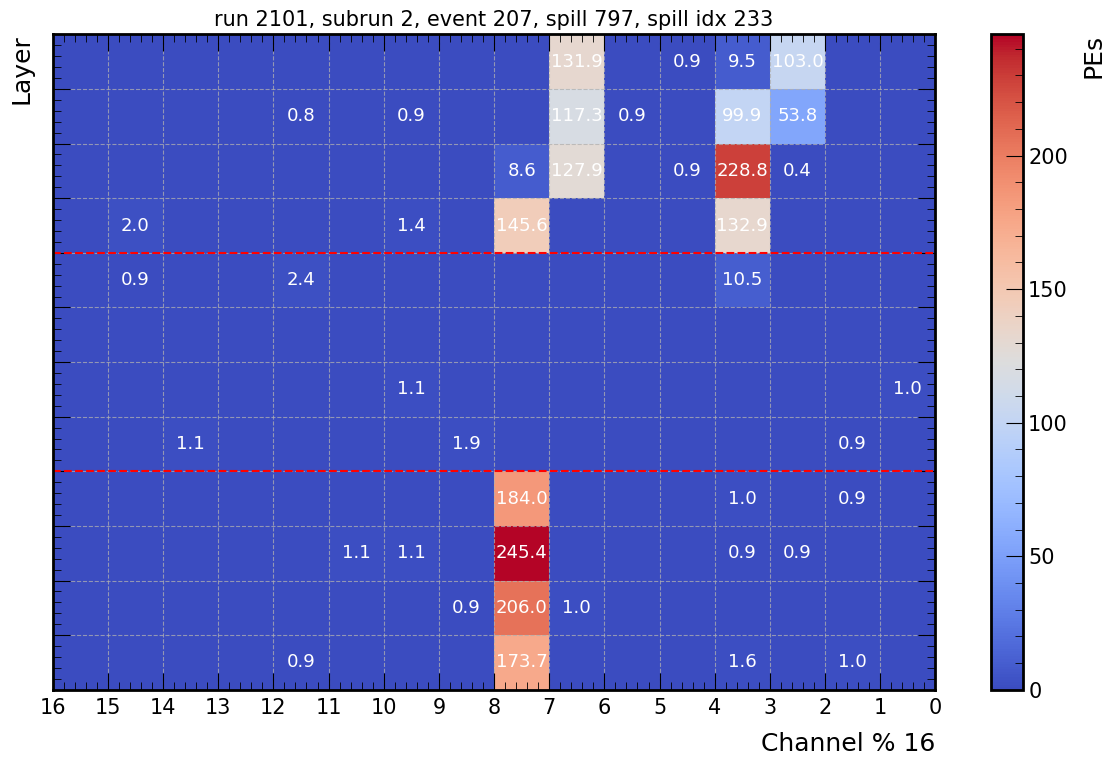

In [37]:
# What's happening below 50 PEs? 
arrays_fail_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==True]
arrays_pass_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==False]

print(arrays_fail_50.fields)
df_arrays_fail_50 = pd.DataFrame({
    "runNumber": ak.flatten(arrays_fail_50.runNumber, axis=None),
    "subrunNumber": ak.flatten(arrays_fail_50.subrunNumber, axis=None),
    "eventNumber": ak.flatten(arrays_fail_50.eventNumber, axis=None),
    "spillNumber": ak.flatten(arrays_fail_50.spillNumber, axis=None),
    "spillIndex": ak.flatten(arrays_fail_50.spillIndex, axis=None)
})

display(df_arrays_fail_50)

df_arrays_fail_50.to_csv(f"arrays_fail_50.csv")

# Automatically get values from the first row (index 0)
index = 30
runNumber = df_arrays_fail_50.iloc[index]['runNumber']
subrunNumber = df_arrays_fail_50.iloc[index]['subrunNumber']
eventNumber = df_arrays_fail_50.iloc[index]['eventNumber']
spillNumber = df_arrays_fail_50.iloc[index]['spillNumber']
spillIndex = df_arrays_fail_50.iloc[index]['spillIndex']

rows = event_display(arrays,
                     runNumber=runNumber,
                     subrunNumber=subrunNumber,
                     eventNumber=eventNumber,
                     spillNumber=spillNumber,
                     spillIndex=spillIndex,
                     fout=f"../Images/EventDisplays/ed_{runNumber}_{subrunNumber}_{eventNumber}_{spillNumber}_{spillIndex}_.png")

    # Get event
this_event = arrays_cut[ 
    (arrays_cut["runNumber"]==runNumber) & 
    (arrays_cut["subrunNumber"]==subrunNumber) &
    (arrays_cut["eventNumber"]==eventNumber) &
    (arrays_cut["spillNumber"]==spillNumber) &
    (arrays_cut["spillIndex"]==spillIndex) 
]

# pr.PrintNEvents(this_event)
# # this_event = arrays_cut[(arrays_cut["eventNumber"]==eventNumber) & (arrays_cut["subrun"]==subrun)]

# # print(len(this_event))
# # pr.PrintNEvents(this_event, 21)
# rows = event_display(arrays, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# rows.to_csv(f"no_cuts_{subrun}_{eventNumber}.csv")
# rows = event_display(arrays_cut, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# # rows = event_display(arrays_50, eventNumber=eventNumber, subrun=subrun, fout=f"../Images/EventDisplays/ed_f{subrun}_{eventNumber}.png")
# rows.to_csv(f"cuts_{subrun}_{eventNumber}.csv")

# display(rows)

In [36]:
# pr.PrintNEvents(arrays_pass_50)
# pr.PrintNEvents(arrays_fail_50)
# print(arrays_fail_50)


---> Wrote:
	../Images/EffAna/h1o_counters_hit_pass_fail.png


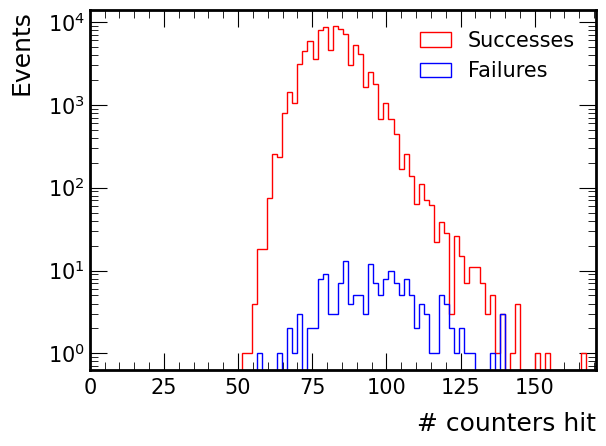

[1.28e+03, 1.38e+03, 1.24e+03, 1.84e+03, ..., 1.43e+03, 1.73e+03, 1.53e+03]
[1.58e+03, 1.79e+03, 1.05e+03, 1.94e+03, ..., 1.52e+03, 2.2e+03, 1.77e+03]

---> Wrote:
	../Images/EffAna/h1o_tot_PEs_pass_fail.png


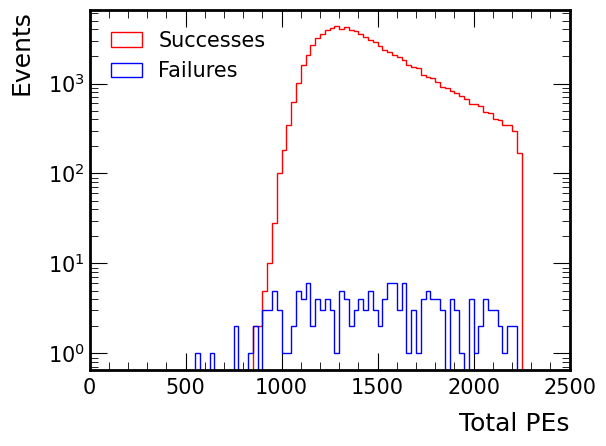

In [38]:
# Plot noise in counters 

# How many counters have PEs under 10? 

# pass_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==False]["PEsTemperatureCorrected"]
# fail_50 = arrays_cut[arrays_cut["fail_50.0"][:, 1]==True]["PEsTemperatureCorrected"]

# print(fail_50[0])
# counters = (arrays_pas_50 < 10) & (fail_50 > 0) 
# print(counters[0])

# print(arrays_pass_50["PEsTemperatureCorrected"])

def get_counter_hits(array=None): # , thres=10):
    counters_hit = array > 0
    # Sum over channels first, then FEBs (event:feb:channel)
    return ak.sum(ak.sum(counters_hit, axis=2), axis=1)

hits_pass_50 = get_counter_hits(arrays_pass_50["PEsTemperatureCorrected"])
hits_fail_50 = get_counter_hits(arrays_fail_50["PEsTemperatureCorrected"])

pl.Plot1DOverlay( 
    {
        "Successes" : ak.flatten(hits_pass_50, axis=None),
        "Failures" : ak.flatten(hits_fail_50, axis=None)
    },
    nbins=100, xmin=0, xmax=512/3, log_y=True,
    xlabel="# counters hit", ylabel="Events",
    fout="../Images/EffAna/h1o_counters_hit_pass_fail.png"
)

def get_tot_PEs(arrays):
    # Sum over each module's layers
    tot_PEs = (
        ak.sum(ak.sum(arrays['PEs_per_layer_L_end'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_T'], axis=-1), axis=-1) +
        ak.sum(ak.sum(arrays['PEs_per_layer_DS'], axis=-1), axis=-1)
    )
    return tot_PEs 

# pr.PrintNEvents(pass_50)
tot_PEs_pass_50 = get_tot_PEs(arrays_pass_50)
tot_PEs_fail_50 = get_tot_PEs(arrays_fail_50) 

print(tot_PEs_pass_50)
print(tot_PEs_fail_50)

pl.Plot1DOverlay( 
    {
        "Successes" : ak.flatten(tot_PEs_pass_50, axis=None),
        "Failures" : ak.flatten(tot_PEs_fail_50, axis=None)
    },
    nbins=100, xmin=0, xmax=2500, log_y=True, log_x=False,
    xlabel="Total PEs", ylabel="Events",
    fout="../Images/EffAna/h1o_tot_PEs_pass_fail.png"
)